In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from dask.distributed import Client

In [3]:
import cartopy.crs as ccrs

In [4]:
import numpy as np

In [5]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

/opt/conda/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45135 instead
  warnings.warn(
2023-06-20 20:22:01,519 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-umf8v_68', purging
2023-06-20 20:22:01,520 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/dask-worker-space/worker-lqqvsjsz', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.13:45135/status,
Dashboard: http://134.245.3.13:45135/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.13:36023,Workers: 4
Dashboard: http://134.245.3.13:45135/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.13:36699,Total threads: 2
Dashboard: http://134.245.3.13:36817/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.13:37369,


In [6]:
threshold=0.005 #minimum speed in m/s

In [7]:
INALT_ds = xr.open_dataset('../output_data/ROMS/Column_test_4000_20090301_RT-42_N-15000_seed-12345.nc') #INALT20.L46-KFS119
INALT_ds

<xarray.Dataset>
Dimensions:     (traj: 15000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [8]:
INALT_2weeks=INALT_ds.where((INALT_ds.obs<[7*2+1]),drop=True) # 2 weeks

In [9]:
INALT_2weeks

<xarray.Dataset>
Dimensions:     (traj: 15000, obs: 15)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 8.023 8.069 8.117 ... 7.535 7.534 7.531
    lat         (traj, obs) float64 -23.56 -23.56 -23.56 ... -23.05 -23.1 -23.14
    z           (traj, obs) float64 235.2 219.8 220.3 ... 2.633e+03 2.614e+03
    time        (traj, obs) datetime64[ns] 2009-03-01 2009-03-02 ... 2009-03-16
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 ... 1.5e+04 1.5e+04 1.5e+04
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [10]:
#Calculate speed (m/s)
dx = 111.3*np.cos(np.deg2rad(-23.25))*INALT_2weeks.lon.diff("obs")*1000
dy = 111.3*INALT_2weeks.lat.diff("obs")*1000
dt = INALT_2weeks.time.diff("obs")/np.timedelta64(1,'s')
speed = ( (dx/dt)**2 + (dy/dt)**2 )**0.5

In [11]:
speed = speed.compute()

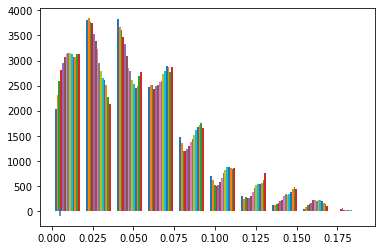

In [12]:
plt.hist(speed)
plt.vlines(x=0.005,ymin=-100,ymax=50);

In [13]:
#Filtering for particles with speed over threshold for two consecutive timesteps
for i in range(13):
    thresholdset=INALT_2weeks.where(
        ((speed[:,i]>threshold) & (speed[:,i+1]>threshold)) | ((speed[:,i]<threshold) & (speed[:,i+1]>threshold)),drop=True).sel()
thresholdset=thresholdset.dropna("traj")

In [14]:
thresholdset

<xarray.Dataset>
Dimensions:     (traj: 13577, obs: 15)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 8.023 8.069 8.117 ... 7.535 7.534 7.531
    lat         (traj, obs) float64 -23.56 -23.56 -23.56 ... -23.05 -23.1 -23.14
    z           (traj, obs) float64 235.2 219.8 220.3 ... 2.633e+03 2.614e+03
    time        (traj, obs) datetime64[ns] 2009-03-01 2009-03-02 ... 2009-03-16
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 ... 1.5e+04 1.5e+04 1.5e+04
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [15]:
# Initial positions and last positions
end=thresholdset.isel(obs=7*2-1)
start=thresholdset.isel(obs=0)

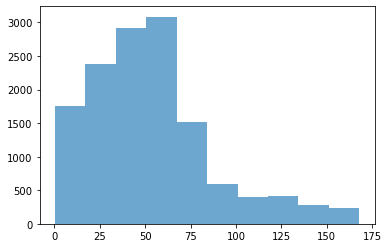

In [16]:
#Distance determination

dist_years_mean = []
dist_years_min = []
dist_years_max = []
dist_n = []
distances = []

for i in range(len(start.traj)): 
    lon1 = start.isel(traj=i)['lon'].compute().data
    lon2 = end.isel(traj=i)['lon'].compute().data
    lat1 = start.isel(traj=i)['lat'].compute().data
    lat2 = end.isel(traj=i)['lat'].compute().data
            
    dx = 111.3 * np.cos(np.deg2rad((lat1+lat2)/2))  * (lon1 - lon2)
    dy = 111.3 * (lat1 - lat2)
            
    distance = np.sqrt(dx**2 + dy**2)
    distances.append(distance)
        
plt.hist(distances, alpha = 0.65)
dist_years_mean.append(np.mean(distances))
dist_years_min.append(np.min(distances))  
dist_years_max.append(np.max(distances))  
dist_n.append(len(distances))

In [17]:
print(dist_n)
print(dist_years_mean)

[13577]
[53.201638642812966]


In [18]:
percentile = np.percentile(distances, 95)
percentile

128.51090097971698

In [19]:
distances = np.array(distances)

In [20]:
filtered = []

for distances in distances:
    if distances < percentile:
        filtered.append(distances)

In [21]:
np.mean(filtered)

48.322096177303195

In [22]:
len(filtered)

12898